In [1]:
import pandas as pd
import numpy as np
import os

In [3]:
# Read in XLSX files
folder_path = "Input"

files = os.listdir(folder_path)

matching_claim = [file for file in files if "Incline Redpoint_Claim_MRL_Record @ " in file]

if not matching_claim:
    print("No matching claim file found.")
else:
    # Use the first matching file found (you may need to adjust this logic if multiple matches are possible)
    claim_file_path = os.path.join(folder_path, matching_claim[0])
    claim_df = pd.read_excel(claim_file_path, sheet_name="Premium_And_Loss_by_Coverage_Cl", skiprows=1)

matching_premium = [file for file in files if "Premium_And_Loss_by_Coverage_Written_Earned Premium_Details_INBG @ " in file]

if not matching_premium:
    print("No matching premium file found.")
else:
    # Use the first matching file found (you may need to adjust this logic if multiple matches are possible)
    premium_file_path = os.path.join(folder_path, matching_premium[0])

    # Step 6: Read in premium xlsx file as a DataFrame
    premium_df = pd.read_excel(premium_file_path, sheet_name="WP detail", skiprows = 7)


### Check: whether reported claim has associated policy number in the Premium BDX

In [15]:
#Check if Claims policy is in the Premium BDX
is_every_inb2_policy_included = all(
    claim_df[claim_df['Program Name'] == 'INB2']['Policy Number'].isin(claim_df['Policy Number'].unique())
)

if is_every_inb2_policy_included:
    print("Every Policy Number in Claim BDX is included in the Premium Policy Numbers.")
else:
    print("Not every Policy Number in Claim BDX is included in the Premium Policy Numbers.")


Every Policy Number in Claim BDX is included in the Premium Policy Numbers.


### Check: Overlapping period claim distribution among Ledger and Insurer


/var/folders/hj/c19t7pn546732llst78lj5tm0000gp/T/ipykernel_65481/3817524387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  premium['Policy Effective Date'] = pd.to_datetime(premium['Policy Effective Date'])
/var/folders/hj/c19t7pn546732llst78lj5tm0000gp/T/ipykernel_65481/3817524387.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claim['Policy Effective Date'] = pd.to_datetime(claim['Policy Effective Date'])


Reinsured Policy Statistics:
       Loss Payment  Loss Reserve
count      5.000000           5.0
mean     788.442000           0.0
std     1763.009908           0.0
min        0.000000           0.0
25%        0.000000           0.0
50%        0.000000           0.0
75%        0.000000           0.0
max     3942.210000           0.0

Insurer Withheld Policy Statistics:
       Loss Payment  Loss Reserve
count    272.000000  2.720000e+02
mean    2546.236985  1.593289e+03
std     5334.665178  3.738020e+03
min        0.000000 -9.094947e-13
25%        0.000000  0.000000e+00
50%        0.000000  0.000000e+00
75%     2741.880000  2.500000e+03
max    32308.050000  2.050000e+04


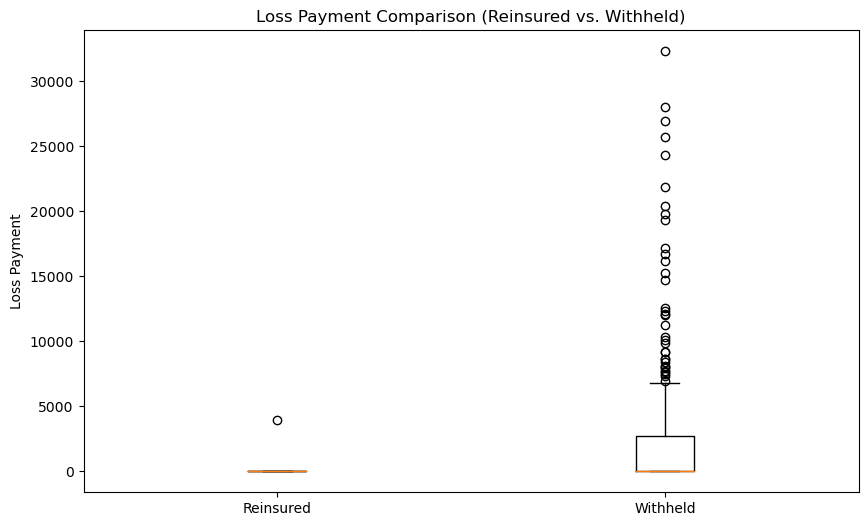

Text(0, 0.5, 'Loss Reserve')

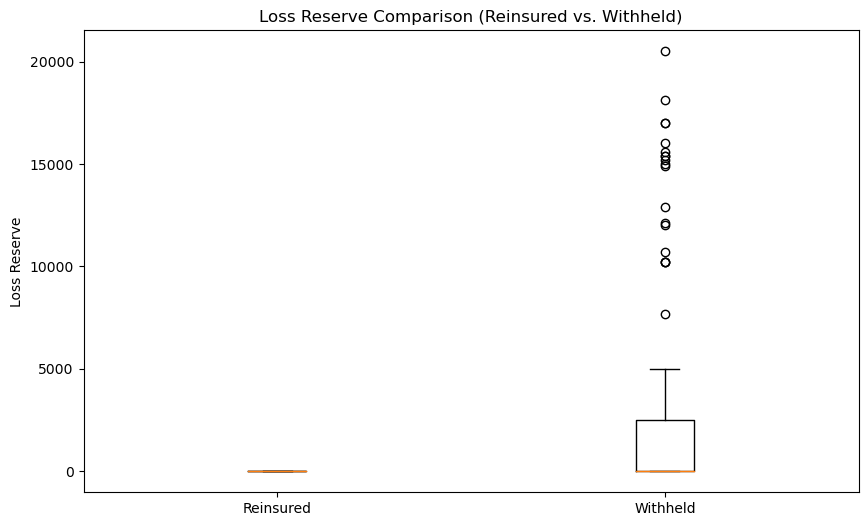

In [5]:
premium_columns = ['Policy Number', 'Policy Effective Date', 'WP', 'EP', 'UEP', 'Ledger']
premium = premium_df[premium_columns]

premium['Policy Effective Date'] = pd.to_datetime(premium['Policy Effective Date'])

# Define the date range
start_date = '2023-03-01'
end_date = '2023-03-16'

# Filter the DataFrame based on the date range
filtered_premium = premium[
    (premium['Policy Effective Date'] >= start_date) & (premium['Policy Effective Date'] <= end_date)]
filtered_premium

aggregated_premium = filtered_premium.groupby('Policy Number').agg({
    'WP': 'sum',
    'EP': 'sum',
    'UEP': 'sum',
    'Ledger': 'first'
}).reset_index()

aggregated_premium
claim_columns = ['Claim Number', 'Policy Number', 'Program Name', 'Policy Effective Date', 'Transaction Type', 'Amount']
claim = claim_df[claim_columns]
claim['Policy Effective Date'] = pd.to_datetime(claim['Policy Effective Date'])

start_date = '2023-03-01'
end_date = '2023-03-16'

filtered_claim = claim[(claim['Policy Effective Date'] >= start_date) & (claim['Policy Effective Date'] <= end_date) & (
            claim['Program Name'] == 'INB2')]
filtered_claim
wide_data = filtered_claim.pivot_table(index=['Claim Number', 'Policy Number', 'Policy Effective Date', 'Program Name'],
                                       columns='Transaction Type', values='Amount', aggfunc='sum',
                                       fill_value=0).reset_index()
wide_data.columns.name = None
wide_data

aggregated_wide_claims = wide_data.groupby('Policy Number').agg({
    'Policy Effective Date': 'first',
    'Program Name': 'first',
    'Loss Payment': 'sum',
    'Loss Reserve': 'sum',
    'Recovery Payment': 'sum'
}).reset_index()

aggregated_wide_claims
merged_data = aggregated_premium.merge(aggregated_wide_claims, on='Policy Number', how='inner')
merged_data
merged_data.to_csv('merged_data.csv', index=False)
### Reporting
reinsured_data = merged_data[merged_data['Ledger'] == 'Ledger']
withheld_data = merged_data[merged_data['Ledger'] == 'Incline']

# For reinsured policies
reinsured_stats = reinsured_data[['Loss Payment', 'Loss Reserve']].describe()

# For withheld policies
withheld_stats = withheld_data[['Loss Payment', 'Loss Reserve']].describe()

print("Reinsured Policy Statistics:")
print(reinsured_stats)
print("\nInsurer Withheld Policy Statistics:")
print(withheld_stats)

import matplotlib.pyplot as plt

# Box plots for Loss Payment
plt.figure(figsize=(10, 6))
plt.title('Loss Payment Comparison (Reinsured vs. Withheld)')
plt.boxplot([reinsured_data['Loss Payment'], withheld_data['Loss Payment']], labels=['Reinsured', 'Withheld'])
plt.ylabel('Loss Payment')
plt.show()

# Box plots for Loss Reserve
plt.figure(figsize=(10, 6))
plt.title('Loss Reserve Comparison (Reinsured vs. Withheld)')
plt.boxplot([reinsured_data['Loss Reserve'], withheld_data['Loss Reserve']], labels=['Reinsured', 'Withheld'])
plt.ylabel('Loss Reserve')
